In [1]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [2]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.3 MB/s eta 0:00:00


In [325]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import f1_score
from IPython.display import clear_output
from tqdm import tqdm
from torcheval.metrics.functional import multiclass_f1_score
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os, sys, json
import urllib.parse as ul

sys.argv.append('.') if len(sys.argv) == 2 else None

base_url = 'https://cloud-api.yandex.net:443/v1/disk/public/resources/download?public_key='
url = ul.quote_plus('https://downloader.disk.yandex.ru/zip/b74b394f0e699adf0d46b56432f8fc6c6e4876194ce6577d917442588fef3f4b/66ed34a2/dnl6cktEN2JrdjdxdzVkWk9HWVJWT21oOXFQODJTKzJlZEdNV25kc2tuL1VUbXg3OFllMGE5NkozU1F0SUtVZnEvSjZicG1SeU9Kb25UM1ZvWG5EYWc9PQ==?uid=0&filename=all_time-series.zip&disposition=attachment&hash=vyzrKD7bkv7qw5dZOGYRVOmh9qP82S%2B2edGMWndskn/UTmx78Ye0a96J3SQtIKUfq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&owner_uid=138056018&tknv=v2')
folder = 'data'
res = os.popen('wget -qO - {}{}'.format(base_url, url)).read()
json_res = json.loads(res)
filename = ul.parse_qs(ul.urlparse(json_res['href']).query)['filename'][0]
os.system("wget '{}' -P '{}' -O '{}'".format(json_res['href'], folder, filename))

0

In [5]:
!unzip all_time-series.zip

Archive:  all_time-series.zip
  inflating: all_time-series/readme.txt  
  inflating: all_time-series/ts_cut/AAL/china/china_close_strategy-1_GSR.npy  
  inflating: all_time-series/ts_cut/AAL/china/china_close_strategy-1_noGSR.npy  
  inflating: all_time-series/ts_cut/AAL/china/china_close_strategy-2_GSR.npy  
  inflating: all_time-series/ts_cut/AAL/china/china_close_strategy-2_noGSR.npy  
  inflating: all_time-series/ts_cut/AAL/china/china_close_strategy-3_GSR.npy  
  inflating: all_time-series/ts_cut/AAL/china/china_close_strategy-3_noGSR.npy  
  inflating: all_time-series/ts_cut/AAL/china/china_close_strategy-4_GSR.npy  
  inflating: all_time-series/ts_cut/AAL/china/china_close_strategy-4_noGSR.npy  
  inflating: all_time-series/ts_cut/AAL/china/china_close_strategy-5_GSR.npy  
  inflating: all_time-series/ts_cut/AAL/china/china_close_strategy-5_noGSR.npy  
  inflating: all_time-series/ts_cut/AAL/china/china_close_strategy-6_GSR.npy  
  inflating: all_time-series/ts_cut/AAL/china/chi

In [6]:
!python generate.py

python3: can't open file '/content/generate.py': [Errno 2] No such file or directory


In [7]:
!mkdir data
!mkdir data/ts_cut
!mkdir data/ts_cut/HCPex

In [234]:
data = {}

path_to_data = r'all_time-series/ts_cut'

import os
import numpy as np
import re

parser_regex = r'(ihb|china|rmet)_(open|close)_strategy-(\d)_(GSR|noGSR).npy'
extractor = re.compile(parser_regex)

items = {atlas_name : {dataset_name : []
                       for dataset_name in ['rmet', 'ihb', 'china']}
         for atlas_name in ['Brainnetome', 'Schaefer200']}

for root, dirs, files in os.walk(path_to_data):
    for file in files:
        atlas = root.split(os.sep)[2]
        source = root.split(os.sep)[3]
        if atlas in ['Brainnetome', 'Schaefer200'] and source in ['rmet', 'ihb', 'china']:
            items[atlas][source].append(np.load(os.path.join(root, file)))

In [232]:
items['Brainnetome']['rmet'][0].shape

(63, 120, 246)

In [235]:
items['Schaefer200']['rmet'][0].shape

(63, 120, 200)

In [10]:
data.shape

(120, 246)

In [11]:
corr_matrix = data.corr()

In [12]:
corr_matrix2 = np.corrcoef(data.T)

In [13]:
corr_matrix.values.flatten().shape

(60516,)

<Axes: >

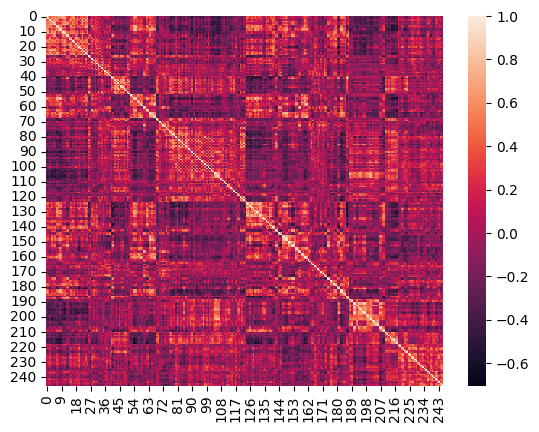

In [14]:
sns.heatmap(corr_matrix)


# Dataset


In [333]:
data = items['Brainnetome']['rmet']

In [ ]:
corr_mat1 = np.corrcoef(data[0][0], rowvar=False)

<Axes: >

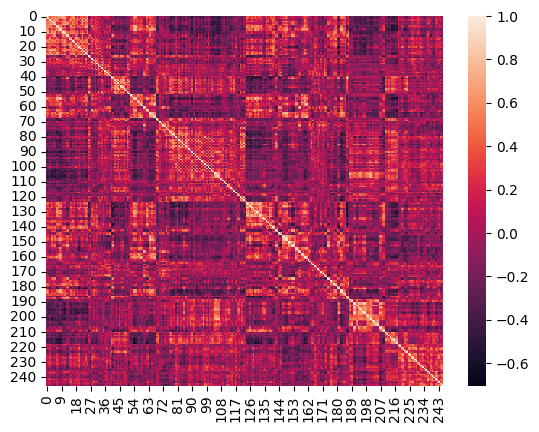

In [ ]:
sns.heatmap(corr_mat1)

In [ ]:
corr_mat2 = np.corrcoef(data[0][37], rowvar=False)

<Axes: >

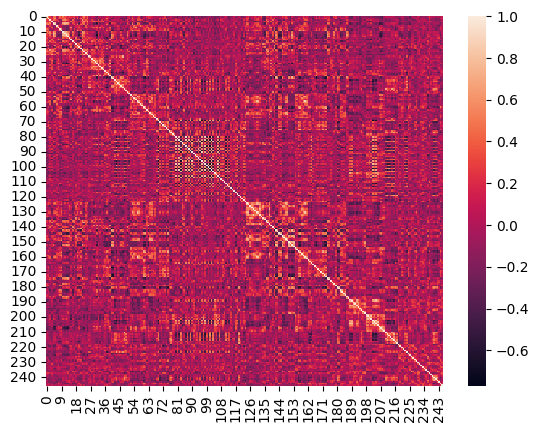

In [ ]:
sns.heatmap(corr_mat2)

In [ ]:
corr2corr = np.corrcoef(corr_mat1, corr_mat2)

<Axes: >

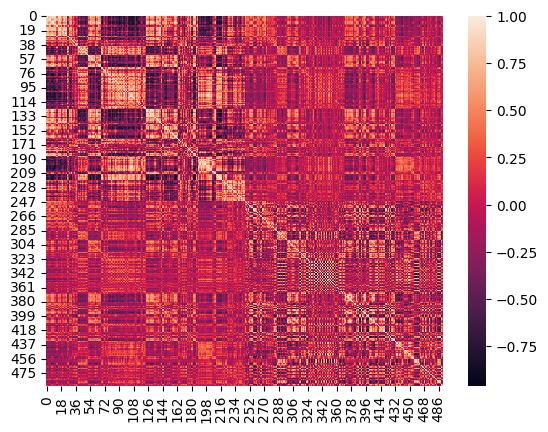

In [ ]:
sns.heatmap(corr2corr)

In [334]:
data = np.array([np.corrcoef(person, rowvar=False) for tag in data for i, person in enumerate(tag)])

In [335]:
data.shape

(1512, 246, 246)

In [336]:
rows, cols = np.triu_indices(data.shape[1])
features = data[:, rows, cols]
labels = np.array([i % 63 for i in range(1512)])

In [337]:
features.shape

(1512, 30381)

In [338]:
labels.shape

(1512,)

In [339]:
features_tensor = torch.tensor(features, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

In [340]:
features_tensor.shape

torch.Size([1512, 30381])

In [341]:
dataset = TensorDataset(features_tensor, labels_tensor)

In [342]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

In [343]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [344]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [345]:
class FLNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.inner1 = nn.Linear(hidden_size, hidden_size)
        self.inner2 = nn.Linear(hidden_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.inner1(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.inner2(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [346]:
def loss_with_regularization(y_pred, y, model, alpha=1e-2, beta=1e-3):
    loss = nn.CrossEntropyLoss()(y_pred, y)

    l2_reg = torch.norm(torch.cat([param.view(-1) for param in model.parameters()]), p=2).item()
    l1_reg = torch.norm(torch.cat([param.view(-1) for param in model.parameters()]), p=1).item()

    loss += alpha * l1_reg + beta * l2_reg
    return loss

In [347]:
def train(model, data_loader, optimizer, loss_fn):
    model.train()

    total_loss = 0
    total_f1 = 0

    for x, y in tqdm(data_loader):

        optimizer.zero_grad()

        output = model(x)
        loss = loss_with_regularization(output, y, model)

        loss.backward()

        total_loss += loss.item()

        y_pred = output.argmax(dim=1)
        f1 = multiclass_f1_score(y_pred, y, average='macro', num_classes=63).item()
        total_f1 += f1

        optimizer.step()

    return total_loss / len(data_loader), total_f1 / len(data_loader)


In [348]:
# валидацонный цикл
@torch.inference_mode()
def evaluate(model, data_loader, loss_fn):
    model.eval()

    total_loss = 0
    total_f1 = 0

    for x, y in tqdm(data_loader):

        output = model(x)

        loss = loss_with_regularization(output, y, model)

        total_loss += loss.item()

        y_pred = output.argmax(dim=1)
        f1 = multiclass_f1_score(y_pred, y, average='macro', num_classes=63).item()
        total_f1 += f1

    return total_loss / len(data_loader), total_f1 / len(data_loader)

In [349]:
# тестовый цикл
@torch.inference_mode()
def test(model, data_loader, loss_fn):
    model.eval()

    total_loss = 0
    total_f1 = 0

    for x, y in tqdm(data_loader):

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        y_pred = output.argmax(dim=1)
        f1 = multiclass_f1_score(y_pred, y, average='macro', num_classes=63).item()
        total_f1 += f1
    clear_output()
    return total_loss / len(data_loader), total_f1 / len(data_loader)

In [381]:
def compute_roc_auc(model, data_loader, num_classes=63):
    # Переключите модель в режим оценки
    model.eval()

    # Инициализируйте списки для хранения предсказанных вероятностей и истинных меток
    all_preds = []
    all_labels = []

    # Отключите градиенты для ускорения вычислений
    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = batch
            outputs = model(inputs)

            # Преобразуйте метки в one-hot кодирование
            labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()

            # Добавьте предсказания и метки в списки
            all_preds.append(outputs)
            all_labels.append(labels_one_hot)

    # Объедините все предсказания и метки в один тензор
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Вычислите ROC AUC для каждого класса и усредните
    roc_auc = roc_auc_score(all_labels.cpu().numpy(), all_preds.cpu().numpy(), average='macro', multi_class='ovr')

    return roc_auc


In [351]:
# вывод графиков
def plot_stats(train_loss, valid_loss, train_f1, valid_f1, title):
    plt.figure(figsize=(16, 5))

    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_f1, label='Train F1-score')
    plt.plot(valid_f1, label='Valid F1-score')
    plt.legend()

    plt.show()

In [352]:
def fit(model, train_loader, valid_loader, optimizer, loss_fn, num_epochs, model_name, title):
    train_loss_history, valid_loss_history = [], []
    train_f1_history, valid_f1_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_f1 = train(model, train_loader, optimizer, loss_fn)
        valid_loss, valid_f1 = evaluate(model, valid_loader, loss_fn)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_f1_history.append(train_f1)
        valid_f1_history.append(valid_f1)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_f1_history, valid_f1_history, title
            )

        print()
        print(f'Max valid F1-score: {max(valid_f1_history):.3f}')
        print(f'Min valid loss: {min(valid_loss_history):.3f}')

In [353]:
LR = 1e-3
NUM_EPOCHS = 3

In [354]:
model = FLNet(input_size=30381, hidden_size=2000, output_size=63)
optim = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

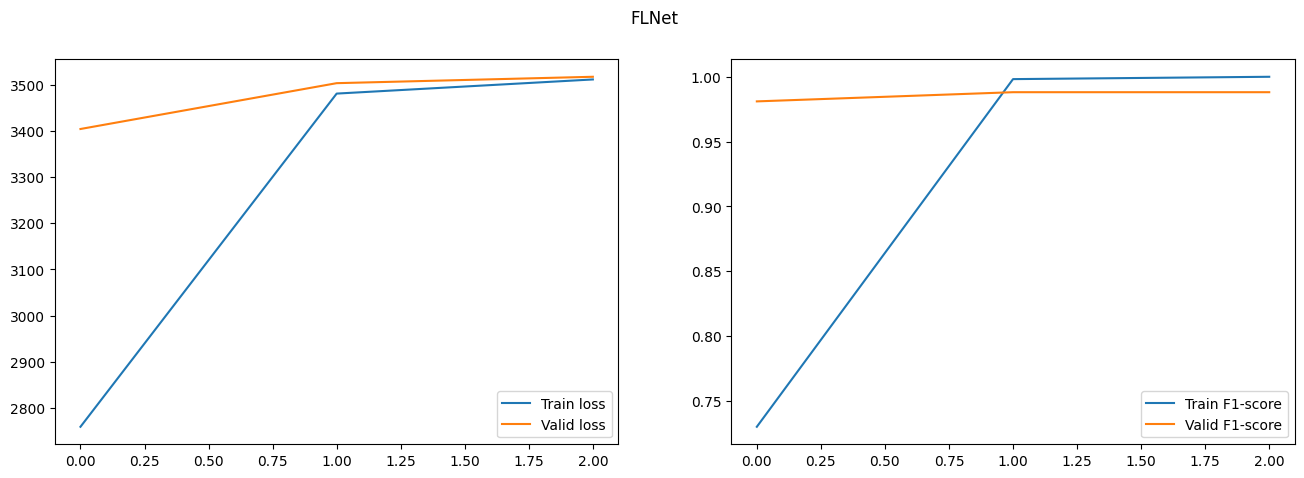


Max valid F1-score: 0.988
Min valid loss: 3404.240


In [355]:
fit(model, train_loader, val_loader,
    optim, criterion, NUM_EPOCHS, 'flnet', "FLNet")

In [356]:
test(model, test_loader, criterion)

(0.014333305713080335, 0.9958333522081375)

In [383]:
roc_auc = compute_roc_auc(model, test_loader, num_classes=63)
print(f'ROC AUC Score: {roc_auc}')

ROC AUC Score: nan


In [81]:
torch.save(model.state_dict(), 'model_weights.pth')

# Dataset on spectrum


In [286]:
data = items['Brainnetome']['rmet']

In [289]:
import numpy.linalg as la

features = torch.zeros((1512, 246))
c = 0
for tag in data:
    for i, person in enumerate(tag):
        corr_matrix = np.corrcoef(person, rowvar=False)
        eigvals = la.eigvals(corr_matrix)
        features[c] = torch.tensor(eigvals)
        c += 1

In [322]:
samples = features[:63]

In [323]:
corr_spec = torch.corrcoef(samples)

<Axes: >

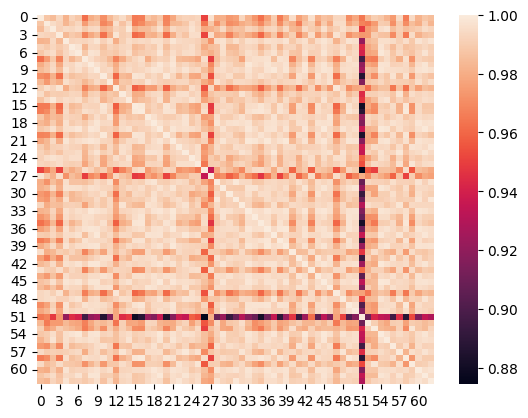

In [324]:
sns.heatmap(corr_spec)

In [290]:
features.shape

torch.Size([1512, 246])

In [291]:
labels = torch.tensor([i % 63 for i in range(1512)])

In [292]:
dataset = TensorDataset(features, labels)

In [293]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

In [294]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [295]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [164]:
class FLNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.inner1 = nn.Linear(hidden_size, hidden_size)
        self.inner2 = nn.Linear(hidden_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.inner1(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.inner2(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [185]:
def loss_with_regularization(y_pred, y, model, alpha=1e-3, beta=1e-4):
    loss = nn.CrossEntropyLoss()(y_pred, y)

    l2_reg = torch.norm(torch.cat([param.view(-1) for param in model.parameters()]), p=2).item()
    l1_reg = torch.norm(torch.cat([param.view(-1) for param in model.parameters()]), p=1).item()

    loss += alpha * l1_reg + beta * l2_reg
    return loss

In [186]:
def train(model, data_loader, optimizer, loss_fn):
    model.train()

    total_loss = 0
    total_f1 = 0

    for x, y in tqdm(data_loader):

        optimizer.zero_grad()

        output = model(x)
        loss = loss_with_regularization(output, y, model)
        # loss = loss_fn(output, y)

        loss.backward()

        total_loss += loss.item()

        y_pred = output.argmax(dim=1)
        f1 = multiclass_f1_score(y_pred, y, average='macro', num_classes=63).item()
        total_f1 += f1

        optimizer.step()

    return total_loss / len(data_loader), total_f1 / len(data_loader)


In [187]:
# валидацонный цикл
@torch.inference_mode()
def evaluate(model, data_loader, loss_fn):
    model.eval()

    total_loss = 0
    total_f1 = 0

    for x, y in tqdm(data_loader):

        output = model(x)

        loss = loss_with_regularization(output, y, model)
        # loss = loss_fn(output, y)

        total_loss += loss.item()

        y_pred = output.argmax(dim=1)
        f1 = multiclass_f1_score(y_pred, y, average='macro', num_classes=63).item()
        total_f1 += f1

    return total_loss / len(data_loader), total_f1 / len(data_loader)

In [188]:
# тестовый цикл
@torch.inference_mode()
def test(model, data_loader, loss_fn):
    model.eval()

    total_loss = 0
    total_f1 = 0

    for x, y in tqdm(data_loader):

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        y_pred = output.argmax(dim=1)
        f1 = multiclass_f1_score(y_pred, y, average='macro', num_classes=63).item()
        total_f1 += f1
    clear_output()
    return total_loss / len(data_loader), total_f1 / len(data_loader)

In [189]:
# вывод графиков
def plot_stats(train_loss, valid_loss, train_f1, valid_f1, title):
    plt.figure(figsize=(16, 5))

    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_f1, label='Train F1-score')
    plt.plot(valid_f1, label='Valid F1-score')
    plt.legend()

    plt.show()

In [190]:
def fit(model, train_loader, valid_loader, optimizer, loss_fn, num_epochs, model_name, title):
    train_loss_history, valid_loss_history = [], []
    train_f1_history, valid_f1_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_f1 = train(model, train_loader, optimizer, loss_fn)
        valid_loss, valid_f1 = evaluate(model, valid_loader, loss_fn)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_f1_history.append(train_f1)
        valid_f1_history.append(valid_f1)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_f1_history, valid_f1_history, title
            )

        print()
        print(f'Max valid F1-score: {max(valid_f1_history):.3f}')
        print(f'Min valid loss: {min(valid_loss_history):.3f}')

In [191]:
LR = 1e-3
NUM_EPOCHS = 3

In [192]:
spec_model = FLNet(input_size=246, hidden_size=2000, output_size=63)
optim = torch.optim.Adam(spec_model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

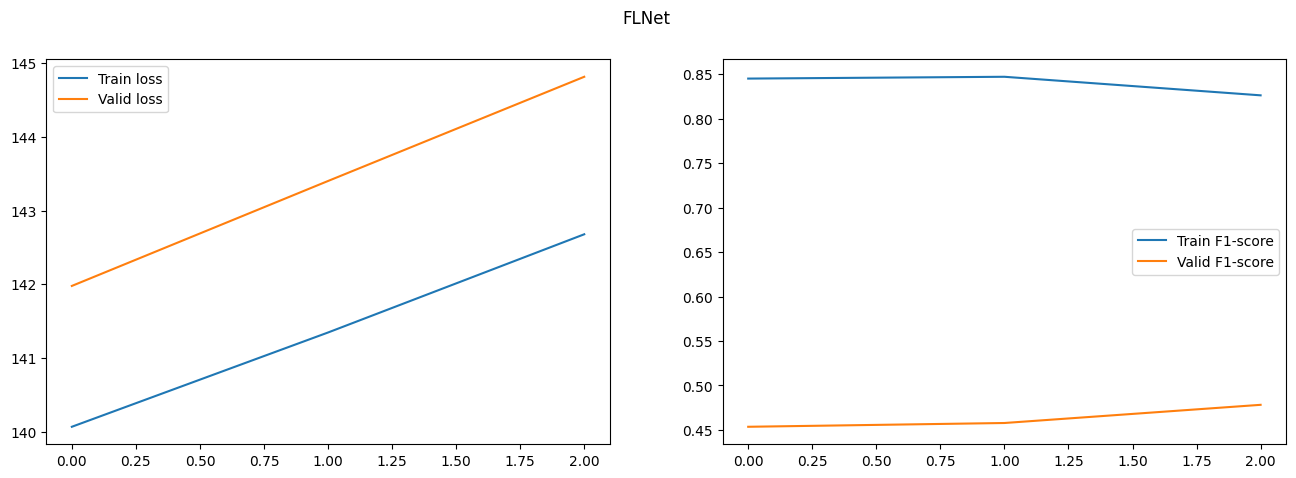


Max valid F1-score: 0.478
Min valid loss: 141.977


In [199]:
fit(spec_model, train_loader, val_loader,
    optim, criterion, NUM_EPOCHS, 'flnet', "FLNet")

In [195]:
test(spec_model, test_loader, criterion)

(2.576990246772766, 0.2525491677224636)